In [ ]:
from copy import copy
import a301_lib
import rioxarray
import cartopy
from matplotlib import pyplot as plt
import pyresample
from pathlib import Path
import cartopy.crs as ccrs
import numpy as np
import os
import pyproj

In [ ]:
all_tifs  = list(Path("..").glob("*tif"))
print(f"{len(all_tifs)=}")
image1  = rioxarray.open_rasterio(all_tifs[0],mask_and_scale = True)
crs = pyproj.CRS.from_epsg(3857)

## check to make sure all images have same extents

In [ ]:
area_def1 = pyresample.utils.rasterio.get_area_def_from_raster(str(all_tifs[0]),projection=crs)
area_def1

In [45]:
area_def2 = pyresample.utils.rasterio.get_area_def_from_raster(str(all_tifs[20]),projection=crs)
area_def2

Area ID: None
Description: None
Projection: {'a': '6378137', 'b': '6378137', 'k': '1', 'lat_ts': '0', 'lon_0': '0', 'nadgrids': '@null', 'no_defs': 'None', 'proj': 'merc', 'type': 'crs', 'units': 'm', 'wktext': 'None', 'x_0': '0', 'y_0': '0'}
Number of columns: 446
Number of rows: 867
Area extent: (-12679500.0, 7978500.0, -12456500.0, 8412000.0)

## use stack to make a 3-d array with time,lat,lon

new_3d.shape=(264, 867, 446)


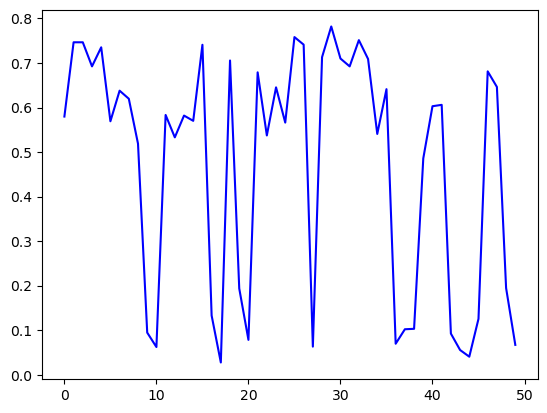

In [59]:
# raster data
big_list = []
for item in all_tifs:
    band_xarray = rioxarray.open_rasterio(item)
    big_list.append(band_xarray.data)
new_3d = np.stack(big_list)
new_3d = new_3d.squeeze()
print(f"{new_3d.shape=}")
one_pixel = new_3d[:,100,100]
plt.plot(one_pixel[:50],'b-')

# for PCA, 
# row = 867, column = 446

## collapse lat/lon into 1 dimension

In [60]:
new2d = new_3d.reshape(264,867*446)
new2d.shape

(264, 386682)

In [7]:
band_xarray.dims

('band', 'y', 'x')

In [8]:
# pixel center coordinates
band_xarray.coords

Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -1.268e+07 -1.268e+07 ... -1.246e+07 -1.246e+07
  * y            (y) float64 8.412e+06 8.411e+06 ... 7.979e+06 7.979e+06
    spatial_ref  int32 0

In [73]:
import pandas as pd
latitude_values = band_xarray.coords['y'].values
longitude_values = band_xarray.coords['x'].values

# Create DataFrames for latitude and longitude values
latitude_df = pd.DataFrame({'Latitude': latitude_values})
longitude_df = pd.DataFrame({'Longitude': longitude_values})

# Save DataFrames to separate CSV files
latitude_csv_path = 'latitude_values.csv'
longitude_csv_path = 'longitude_values.csv'
latitude_df.to_csv(latitude_csv_path, index=False)
longitude_df.to_csv(longitude_csv_path, index=False)

print(f"Latitude values saved to {latitude_csv_path}")
print(f"Longitude values saved to {longitude_csv_path}")


Latitude values saved to latitude_values.csv
Longitude values saved to longitude_values.csv


In [83]:
# Specify the folder path
folder_path = "C:/Users/aniss/repos2/a448_2024/asz/NDVI data"

# List to store NDVI data for each month
ndvi_data = []

# Loop through the years 2001-2022
for year in range(2001, 2023):
    year_str = str(year)

    # List to store NDVI data for each month in the current year
    monthly_ndvi = []

    # Loop through the months
    for month in ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]:
        # Create the filename based on the year and month
        filename = f"{month.lower()}_{year_str}.tif"
        file_path = os.path.join(folder_path, filename)

        # Read the GeoTIFF file using rioxarray
        ndvi = rioxarray.open_rasterio(file_path)

        # mean NDVI value
        monthly_ndvi.append(ndvi.mean().values.item())

    # Append the monthly NDVI data for the current year to the main list
    ndvi_data.append(monthly_ndvi)
    
columns = ["January", "February", "March", "April", "May", "June", "July", "August", 
           "September", "October", "November", "December"]

df = pd.DataFrame(ndvi_data, columns=columns)

df["Year"] = range(2001, 2023)

df.set_index("Year", inplace=True)

print(df)

       January  February     March     April       May      June      July  \
Year                                                                         
2001  0.132622  0.136847  0.102167  0.400332  0.578068  0.669026  0.680520   
2002  0.065381  0.153331  0.102040  0.201156  0.452203  0.649174  0.678187   
2003  0.157332  0.149948  0.107067  0.409660  0.548730  0.650367  0.665027   
2004  0.113162  0.126426  0.110691  0.367217  0.473647  0.602150  0.658384   
2005  0.072874  0.118106  0.069764  0.409235  0.505192  0.641492  0.649931   
2006  0.084545  0.127742  0.261644  0.432472  0.584070  0.654440  0.647535   
2007  0.165429  0.109355  0.114838  0.407225  0.553162  0.614631  0.646542   
2008  0.115617  0.105244  0.074201  0.396067  0.548180  0.666661  0.673587   
2009  0.149493  0.114909  0.069865  0.337164  0.433556  0.674840  0.686098   
2010  0.123088  0.157514  0.326527  0.413192  0.549398  0.682816  0.657709   
2011  0.139997  0.131270  0.142269  0.383609  0.558253  0.654906

In [12]:
print(f"{type(band_xarray.attrs)=}\n\n{band_xarray.attrs=}")
print(f"\n{band_xarray.rio.crs=}")

type(band_xarray.attrs)=<class 'dict'>

band_xarray.attrs={'AREA_OR_POINT': 'Area', 'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': '250m_16_days_NDVI'}

band_xarray.rio.crs=CRS.from_epsg(3857)


In [13]:
# affine transform
band_xarray.rio.transform()

Affine(500.0, 0.0, -12679500.0,
       0.0, -500.0, 8412000.0)

In [14]:
out = band_xarray.rio.transform()
out.f

8412000.0

In [16]:
band_xarray.rio.bounds()
# ll_x, ur_x, ll_y, ur_y

(-12679500.0, 7978500.0, -12456500.0, 8412000.0)

In [17]:
# image width and height
band_xarray.rio.width, band_xarray.rio.height

(446, 867)

In [19]:
# x and y dimension names
band_xarray.rio.x_dim, band_xarray.rio.y_dim

('x', 'y')

In [55]:
ndvi_raster = band_xarray.data
print(f"{ndvi_raster.shape=}")
#
# squeeze out the unneeded dimension
#
ndvi_raster = ndvi_raster.squeeze()
print(f"{ndvi_raster.shape=}")

ndvi_raster.shape=(1, 867, 446)
ndvi_raster.shape=(867, 446)


In [56]:
nrows, ncols = ndvi_raster.shape
ll_x, ll_y = band_xarray.rio.transform()*(0,nrows+1)
ur_x, ur_y = band_xarray.rio.transform()*(ncols+1,0)
extent = (ll_x,ur_x, ll_y, ur_y)
extent

(-12679500.0, -12456000.0, 7978000.0, 8412000.0)

## cartopy map

In [52]:
band_xarray[0]

<xarray.DataArray (y: 867, x: 446)>
array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       ...,
       [-0.3   , -0.3   , -0.3   , ...,  0.8727,  0.8727,  0.8659],
       [-0.3   , -0.3   , -0.3   , ...,  0.8856,  0.8496,  0.8416],
       [-0.3   , -0.3   , -0.3   , ...,  0.8886,  0.8895,  0.8707]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.268e+07 -1.268e+07 ... -1.246e+07 -1.246e+07
  * y            (y) float64 8.412e+06 8.411e+06 ... 7.979e+06 7.979e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      250m_16_days_NDVI

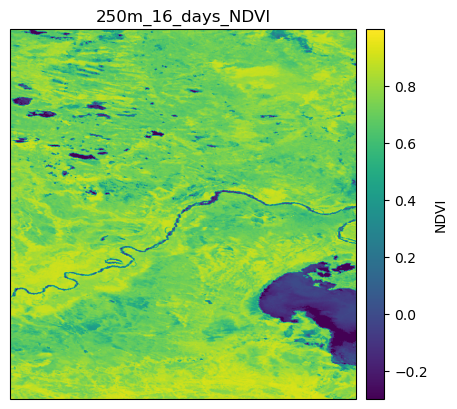

In [45]:
# Define the Cartopy projection using the EPSG code (3857 for Web Mercator)
projection = ccrs.epsg(3857)
bounds = band_xarray.rio.bounds()
ll_x, ur_x, ll_y, ur_y = bounds

# zoom in 
specific_area_bounds = (ll_x + 2e6, ur_x - 1e6, ll_y + 1e6, ur_y - 1e6)

# Create a Cartopy GeoAxes with the specified projection
fig, ax = plt.subplots(subplot_kw={'projection': projection})

# Set the extent of the map to focus on the specific area
ax.set_extent(specific_area_bounds, crs=projection)

# Plot the raster data using imshow from Cartopy
img = ax.imshow(band_xarray.data[0], extent=bounds, origin='upper', transform=projection, cmap='viridis')

# Add a colorbar
cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('NDVI')

# Set plot title
plt.title(band_xarray.attrs['long_name'])

# Show the plot
plt.show()


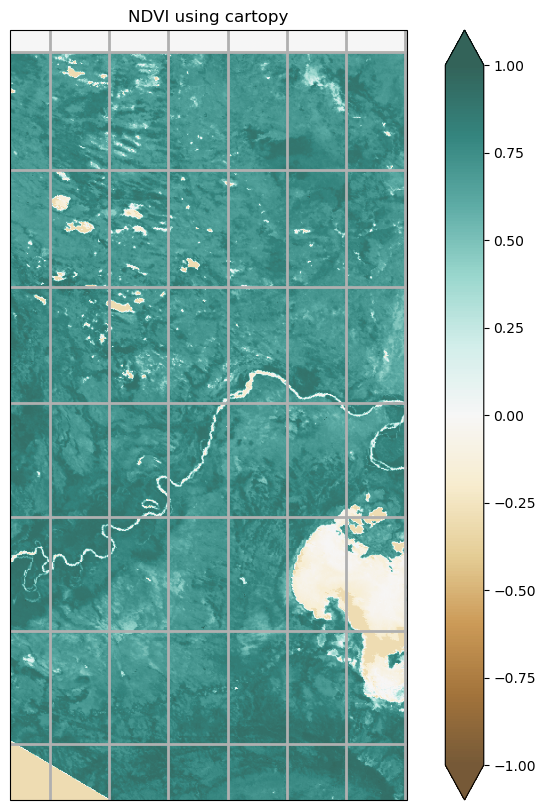

In [74]:
# Choose the BrBG colormap
pal = copy(plt.get_cmap("BrBG"))

fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": cartopy_crs})
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale="coarse", levels=[1, 2, 3]))
ax.set_extent(cartopy_crs.bounds, cartopy_crs)
cs = ax.imshow(
    ndvi_raster,
    transform=cartopy_crs,
    extent=extent,
    origin="upper",
    alpha=0.8,
    cmap=pal,
    norm=the_norm,
)
ax.set(title="NDVI using cartopy")
fig.colorbar(cs, extend="both");